## 

## Investigate Correlation mcc and performance

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../')

In [3]:
import neptune

In [5]:
# https://docs.neptune.ai/api/project/#fetch_runs_table

project = neptune.init_project(
    project="yuuk1/tsdr",
    mode="read-only",
)
runs_table_df = project.fetch_runs_table(state="inactive").to_pandas()

https://app.neptune.ai/yuuk1/tsdr/


In [11]:
runs_table_df[["experiment_id", "sys/creation_time"]].groupby("experiment_id").min().sort_values("sys/creation_time", ascending=False)

,sys/creation_time
experiment_id,
20231006115708,2023-10-06 02:57:12.262000+00:00
20231006014933,2023-10-05 16:49:37.395000+00:00
20230921060302,2023-09-20 21:10:24.142000+00:00
20230919225512,2023-09-19 13:55:15.783000+00:00
20230918231712,2023-09-18 14:17:15.851000+00:00
...,...
20230410222507,2023-04-10 13:25:11.260000+00:00
20230410145022,2023-04-10 05:50:25.332000+00:00
20230410132132,2023-04-10 04:21:35.395000+00:00


In [14]:
def convert_to_dataset_name(x: pd.Series) -> str:
    match x["dataset/target_app"], x["dataset/metric_types/middlewares"], x["dataset/use_manually_selected_metrics"]:
        case "sock-shop", _, True:
            return "SS-small"
        case "sock-shop", False, False:
            return "SS-medium"
        case "sock-shop", True, False:
            return "SS-large"
        case "train-ticket", _, True:
            return "TT-small"
        case "train-ticket", False, False:
            return "TT-medium"
        case "train-ticket", True, False:
            return "TT-large"
        case _:
            raise ValueError(f"Unknown combination:")


In [13]:
target_df = runs_table_df[runs_table_df["sys/failed"] == False].sort_values(by="sys/creation_time")[
    runs_table_df["experiment_id"].isin(["20231006014933", "20231006115708"])
].filter(
    regex="^sys/id|experiment_id|dataset/.+|parameters/.*|scores/.*",
).dropna(axis=1, how="all")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(target_df)

/tmp/ipykernel_3511820/3272112275.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_df = runs_table_df[runs_table_df["sys/failed"] == False].sort_values(by="sys/creation_time")[


,sys/id,dataset/dataset_id,dataset/metric_types/containers,dataset/metric_types/middlewares,dataset/metric_types/nodes,dataset/metric_types/services,dataset/sampling_scale_factor,dataset/target_app,dataset/time_range/end,dataset/time_range/start,dataset/use_manually_selected_metrics,experiment_id,parameters/enable_multireducer,parameters/enable_unireducer,parameters/step1_changepoint_cost_model,parameters/step1_changepoint_penalty,parameters/step1_changepoint_search_method,parameters/step1_method_name,parameters/step2_changepoint_kde_bandwidth,parameters/step2_changepoint_kde_bandwidth_adjust,parameters/step2_changepoint_segment_selection_method,parameters/step2_clustering_granularity,parameters/step2_clustering_method_name,scores/RS_AC_1,scores/RS_AC_2,scores/RS_AC_3,scores/RS_AC_4,scores/RS_AC_5,scores/RS_AVG_1,scores/RS_AVG_2,scores/RS_AVG_3,scores/RS_AVG_4,scores/RS_AVG_5,scores/accuracy,scores/cause_metrics/bacc_mean,scores/cause_metrics/f1_score_mean,scores/cause_metrics/fn_mean,scores/cause_metrics/fp_mean,scores/cause_metrics/mcc_mean,scores/cause_metrics/num_found_mean,scores/cause_metrics/num_mandatory_found_mean,scores/cause_metrics/num_mandatory_total_mean,scores/cause_metrics/num_total_mean,scores/cause_metrics/precision_mean,scores/cause_metrics/proportion_mandatory_mean,scores/cause_metrics/proportion_mean,scores/cause_metrics/recall_mandatory_mean,scores/cause_metrics/recall_mean,scores/cause_metrics/specificity_mean,scores/cause_metrics/tn_mean,scores/cause_metrics/tp_mean,scores/elapsed_time,scores/elapsed_time_max,scores/elapsed_time_min,scores/fn,scores/mandatory_accuracy,scores/mandatory_fn,scores/mandatory_tp,scores/num_series/containers,scores/num_series/middlewares,scores/num_series/services,scores/num_series/total,scores/reduction_rate_max,scores/reduction_rate_mean,scores/reduction_rate_min,scores/tp
35,TSDR-1837,9n6mf,True,False,False,True,1.0,sock-shop,0.0,0.0,True,20231006014933,True,True,l2,bic,pelt,changepoint,0.2,1.0,weighted_max,service,changepoint-kde,0.021328,0.042091,0.062305,0.081985,0.101147,0.021328,0.031710,0.041908,0.051927,0.061771,0.9750,0.595345,0.041557,0.1250,43.5250,0.049133,1.7125,0.8750,1.0000,2.00,0.021328,0.021328,0.041274,0.875000,0.875000,0.315689,19.9250,0.8750,1.853585,2.4527,1.6209,2.0,0.8750,10.0,70.0,0/0/65,NaN,0/0/15,44/64/80,0.625000,0.312703,0.029851,78.0
34,TSDR-1838,9n6mf,True,False,False,True,1.0,sock-shop,0.0,0.0,False,20231006014933,True,True,l2,bic,pelt,changepoint,0.2,1.0,weighted_max,service,changepoint-kde,0.040308,0.078490,0.114687,0.149024,0.181620,0.040308,0.059399,0.077828,0.095627,0.112826,1.0000,0.658396,0.076366,0.7250,95.0250,0.096370,8.5500,3.7125,4.4375,10.55,0.040308,0.040308,0.098267,0.840625,0.840625,0.476167,85.8750,3.7125,3.646671,4.4450,3.1503,0.0,0.9375,5.0,75.0,0/0/484,NaN,0/0/15,98/185/499,0.741935,0.469407,0.177665,80.0
33,TSDR-1839,9n6mf,True,True,False,True,1.0,sock-shop,0.0,0.0,False,20231006014933,True,True,l2,bic,pelt,changepoint,0.2,1.0,weighted_max,service,changepoint-kde,0.008818,0.017537,0.026157,0.034681,0.043109,0.008818,0.013177,0.017504,0.021798,0.026060,1.0000,0.662647,0.017404,1.5875,604.4750,0.045084,10.7500,5.2125,6.8000,14.60,0.008818,0.008818,0.018720,0.773883,0.773883,0.551412,736.1750,5.2125,19.131758,25.3574,14.9755,0.0,0.9625,3.0,77.0,0/0/484,0/0/6294,0/0/15,609/1347/6793,0.753007,0.549889,0.346074,80.0
32,TSDR-1840,9n6mf,True,False,False,True,1.0,sock-shop,0.0,0.0,True,20231006014933,True,True,l2,bic,pelt,changepoint,0.4,1.0,weighted_max,service,changepoint-kde,0.022927,0.045184,0.066794,0.087777,0.108154,0.022927,0.034056,0.044968,0.055671,0.066167,0.9750,0.611807,0.044557,0.1250,41.4375,0.058351,1.7125,0.8750,1.0000,2.00,0.022927,0.022927,0.044335,0.875000,0.875000,0.348614,22.0125,0.8750,1.958040,2.4498,1.7140,2.0,0.8750,10.0,70.0,0/0/65,NaN,0/0/15,42/64/80,0.703125,0.345116,0.046154,78.0
31,TSDR-1841,9n6mf,True,False,False,True,1.0,sock-shop,0.0,0.0,False,20231006014933,True,True,l2,bic,pelt,changepoint,0.4,1.0

In [15]:
target_df["dataset_name"] = target_df.apply(convert_to_dataset_name, axis=1)

In [49]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    tsdr_results_df = target_df.rename(columns={
        "scores/cause_metrics/bacc_mean": "bacc",
        "scores/cause_metrics/mcc_mean": "mcc",
        "scores/cause_metrics/specificity_mean": "rrate",
        "scores/cause_metrics/recall_mandatory_mean": "recall",
        "scores/cause_metrics/proportion_mandatory_mean": "proportion",
        "scores/cause_metrics/specificity_mandatory_mean": "specificity",
        "scores/elapsed_time": "elapsed_time",
    }).filter(
        regex="^(sys/id|dataset_name|bacc|mcc|rrate|recall|proportion|specificity|elapsed_time)$|search|bandwidth",
        axis=1,
    )
    display(tsdr_results_df)

,sys/id,parameters/step1_changepoint_search_method,parameters/step2_changepoint_kde_bandwidth,parameters/step2_changepoint_kde_bandwidth_adjust,bacc,mcc,proportion,recall,rrate,elapsed_time,dataset_name
35,TSDR-1837,pelt,0.2,1.0,0.595345,0.049133,0.021328,0.875000,0.315689,1.853585,SS-small
34,TSDR-1838,pelt,0.2,1.0,0.658396,0.096370,0.040308,0.840625,0.476167,3.646671,SS-medium
33,TSDR-1839,pelt,0.2,1.0,0.662647,0.045084,0.008818,0.773883,0.551412,19.131758,SS-large
32,TSDR-1840,pelt,0.4,1.0,0.611807,0.058351,0.022927,0.875000,0.348614,1.958040,SS-small
31,TSDR-1841,pelt,0.4,1.0,0.666158,0.102238,0.042188,0.840625,0.491692,3.706541,SS-medium
30,TSDR-1842,pelt,0.4,1.0,0.673574,0.048186,0.008999,0.798778,0.548370,19.170409,SS-large
29,TSDR-1843,pelt,0.6,1.0,0.640605,0.076711,0.024471,0.925000,0.356211,1.979745,SS-small
28,TSDR-1844,pelt,0.6,1.0,0.699343,0.124945,0.044932,0.908333,0.490353,3.743485,SS-medium
27,TSDR-1845,pelt,0.6,1.0,0.705470,0.056554,0.009393,0.889017,0.521924,19.142068,SS-large
26,TSDR-1846,pelt,0.8,1.0,0.661396,0.087903,0.025871,0.975000,0.347791,1.996100,SS-small


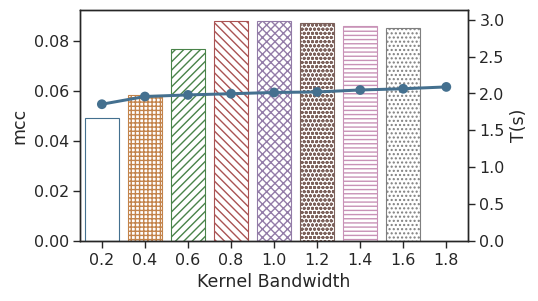

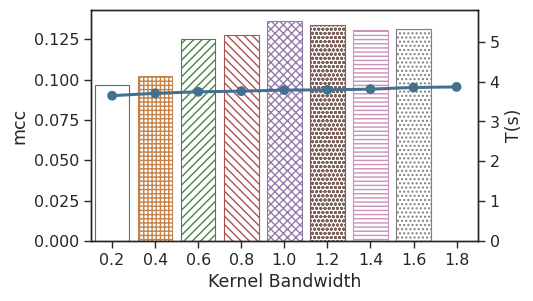

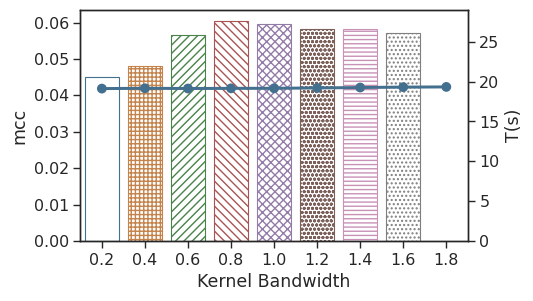

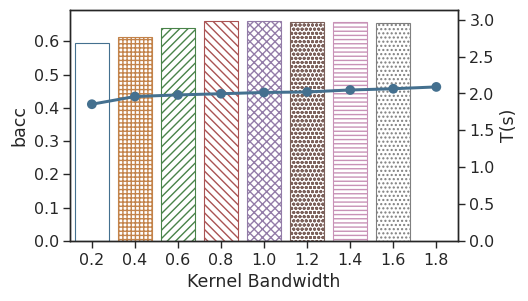

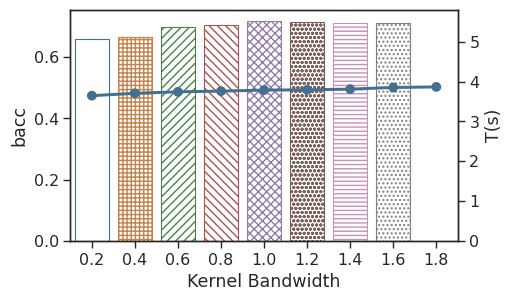

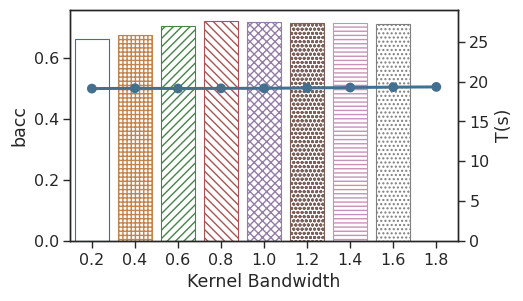

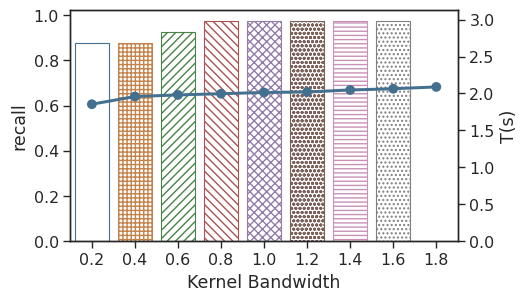

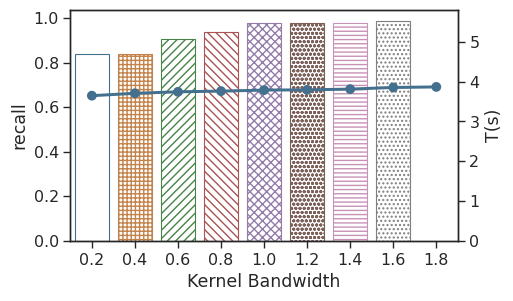

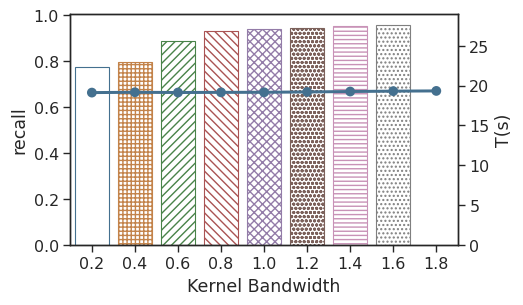

In [51]:
from itertools import cycle
import seaborn as sns

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)
sns.set_palette("tab10", 8, 0.5)

def plot_tsdr_perf_and_time(data_df: pd.DataFrame, dataset: str, metric: str):
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    ax2 = ax.twinx()

    data_df = data_df[data_df["dataset_name"] == dataset]
    bar = sns.barplot(
        data=data_df, x="parameters/step2_changepoint_kde_bandwidth", y=metric,# hue="combination",
        alpha=1, color="none", fill=None, 
        ax=ax,
    )
    num_bar = len(bar.patches)
    edge_colors = sum(map(lambda c: [c] * num_bar, sns.color_palette()), [])
    # https://stackoverflow.com/questions/76233164/how-to-add-hatches-to-histplot-bars-and-legend
    hatchs = ["","++++","////","\\\\\\\\","xxxx", "oooo", "----", "....", "****", "||||||||", "o-o-o-o-o", "x-x-x-x-x", "+-+-+"]
    # for container, hatch, handle, color in zip(ax.containers, hatchs, ax.get_legend().legend_handles, sns.color_palette()):
    for patch, hatch, color in zip(bar.patches, hatchs, cycle(sns.color_palette())):
        patch.set_hatch(hatch)
        patch.set_edgecolor(color)
    #     handle.set_hatch(hatch)
    #     handle.set_edgecolor(color)
    #     for rectangle in container:
    #         rectangle.set_hatch(hatch)
    #         rectangle.set_edgecolor(color)

    markers = ["o", "s", "D", "v", "^", "P", "X", "p", "d"]
    sns.pointplot(
        data=data_df, x="parameters/step2_changepoint_kde_bandwidth", y="elapsed_time",# hue="combination",
        # order=[], hue_order=[],
        dodge=0.5,
        markers=markers, linestyles=["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"],
        ax=ax2,
    )

    ax.set_xlabel("Kernel Bandwidth")
    ax.set_ylabel(metric)
    ax2.set_ylabel("T(s)")
    ymax = data_df["elapsed_time"].max() * 1.5
    ax2.set_ylim(ymin=0, ymax=ymax)
    # ax2.get_legend().remove()
    # sns.move_legend(
    #     ax, "lower center",
    #     bbox_to_anchor=(.5, 1), ncol=3, title="Parameter Set (search, cost, penalty)", frameon=False,
    # )

    fig.savefig(f"materials/plot_tsdr_params_sensitivity_{dataset}_{metric}.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    fig.clf()
    plt.close(fig=fig)


plot_df = tsdr_results_df.reset_index()
# plot_df["combination"] = "(" + plot_df["search_method"] + "," + plot_df["cost_model"] + "," + plot_df["penalty"].astype(str) + ")"

for metric in ["mcc", "bacc", "recall"]:
    for dataset in ["SS-small", "SS-medium", "SS-large"]:
        plot_tsdr_perf_and_time(plot_df, dataset, metric)